# Data Overview

Before we dig too deeply into the data we should understand the data format a little bit better.

At its core, the OpenSNP  has 4 components each . A CSV file, several text files, several image files, and another CSV file corresponding to the image files. We will be ignoring the image data during this exploration.

The CSV file is delimitted by ';' and there are a number of rows, each corresponding to a question that a user answered. Each row corresponds to a different user. User's do not need to answer any question, in fact most of them do not. To add further complication, the answers are primarily free-form and not normalized to any standard.

Each text file corresponds to a single user (and a single user may have more than 1 text file associated with them). The text files contain a list of genetic variants that were identified in the user's genetic data.

The genetic variant information in this dataset was uploaded by users and collected and analyzed through various services such as [23andMe](https://www.23andme.com/), [deCODEme](https://www.decode.com/decode-launches-decodeme/), or [FamilyTreeDNA](https://www.familytreedna.com/) (the source is listed in the `.txt` files and the survey information was collected through [OpenSNP](https://www.opensnp.org/)

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls ../data/*csv

../data/phenotypes_201811100342.csv


In [3]:
!ls ../data/*txt | wc -l

2132


In [4]:
!ls ../data/* | wc -l

2137


In [5]:
# Assign the file that we are looking at
data_file = "../data/phenotypes_201811100342.csv"

In [6]:
# We know the column name we are interested
col_name_myers = 'Myers-Briggs Type Indicator'

In [7]:
# Load the CSV into a dataframe
df = pd.read_csv(data_file, delimiter=";")

# Initial Data Exploration
Now that we understand the data and we have loaded it into a dataframe, we will take a look at it.

Let's start by looking at the number os users, the number of questions answered, and then determine how many people answered each question.

## Summary CSV File

In [8]:
# Print out the row, column count
df.shape

(4707, 550)

In [9]:
# Display the first 5 user submissions
df.head()

,user_id,genotype_filename,date_of_birth,chrom_sex,openhumans_name,Retrognathia (Marfan Syndrome),Eye pigmentation,Vegetarianism/Preference for Meat,Form of foot,Eye color,...,Severe Acne,Sleep duration,"Optimistic, empathetic, handles stress well",Response to Codeine,Fibromyalgia Response to SRI drugs,Suicidality,Rosacea,Eye Color - Heterochromia,GREEK DNA,Supernumerary nipples
0,4134,4134.23andme.2800,rather not say,rather not say,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,885,885.23andme-exome-vcf.994,1982,XY,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,919,919.ftdna-illumina.455,rather not say,rather not say,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2953,2953.ftdna-illumina.1885,1993,XY,-,-,-,-,-,Dark brown,...,-,-,-,-,-,-,-,-,-,-
4,6598,6598.23andme.5001,rather not say,rather not say,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-


In [10]:
# Print out each column by alphabetical order
for column in sorted(df.columns):
    print(column)

 African
 Medium blonde, medium tone skims blood type o+
 vitiligo 
(Male) Nipple's size
(male) penis releases pre-cum when sexually aroused.
12
33
5-HTP effectiveness
A+
A- (cisA2B3)
AB +
ABH Blood Group (antigens) 
ABO Rh
ABO Rh 
ACT math
ACT reading
ACT science
ADHD
ADHD? Subtype?
ALS
ASMR
Ability to Tan
Ability to find a bug in openSNP
Abnormal Blood Pressure
Academic degree
Acromegaly
Acrophobia
Adult Second Language Acquistion Aptitude
Affinity For Animals
Affinity to Cannabis
Age learned to read
Age you had a heart attack
Age you started wearing glasses
Alcohol Consumption (per week)
Alcoholism
Allergic rhinitis
Allergic to Lexapro (Escitalopram)
Allergic/bad reaction to fish oil supplements
Allergy to Egg Whites
Allergy to Hair Dye
Allergy to Strawberries, Tomatoes, Citrus
Allergy to artificial grape flavoring
Alzheimer's Disease 
Am I a duck?
Ambition
Amblyopia
Amount of Body Hair (Male)
Ancestry
Anemic?
Anorexia nervosa or ednos
Anorgasmia
Anxiety
Aortic Insufficiency (Regurg

In [11]:
# Print a count of each column
(df != '-').sum(axis = 0, skipna = True)

/mnt/c/Users/10150935/Documents/linux/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


user_id                      4707
genotype_filename            4707
date_of_birth                4707
chrom_sex                    4707
openhumans_name               305
                             ... 
Suicidality                     7
Rosacea                         3
Eye Color - Heterochromia       9
GREEK DNA                       0
Supernumerary nipples           2
Length: 550, dtype: int64

In [12]:
# Let's get the sum, only for the columns we care about
(df != '-').sum(axis = 0, skipna = True)[col_name_myers]


289

What's going on here! The website said there were 299 entries.

Upon closer inspection, we see that the website has a setion labeled "Already answered on previous submission." That probably acounts for the missing ten, and that would likely indicate thate we have 10 users who submitted twice. We'll look into this later.

For now let's plot some of the data out.

In [78]:
# Add a new column to the dataframe with a count of how many answers were given
count_df = (df != '-').sum(axis = 1, skipna = True)
df.insert(1, column='count', value=count_df)

ValueError: cannot insert count, already exists

In [94]:
# create a variable with just the myers briggs personality types
myers_responders = df[df != '-'][col_name_myers].dropna().str.upper()
print(myers_responders)

3       INTJ
85      INTP
90      INFP
105     ENTP
113     ENTJ
        ... 
4625    ISTJ
4646    INFP
4664    INTJ
4682    ENTJ
4692    INTP
Name: Myers-Briggs Type Indicator, Length: 288, dtype: object


In [95]:
personality_types = ['INTJ', 'INTP', 'ENTJ', 'ENTP', \
                           'INFJ', 'INFP', 'ENFJ', 'ENFP', \
                           'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ', \
                           'ISTP', 'ISFP', 'ESTP', 'ESFP']

In [96]:
# obtaining the frequency of each personality type
personality_counts = []
for item in personality_types:
    personality_counts.append((myers_responders == item).sum(axis = 0))
   
print(personality_counts)

[47, 72, 20, 16, 23, 32, 13, 15, 12, 2, 2, 1, 2, 0, 0, 1]


In [97]:
# turning personality counts into percentages
personality_percents = []
for item in personality_counts:
    percent = (item /289)*100
    personality_percents.append(percent)
print(personality_percents)

[16.26297577854671, 24.91349480968858, 6.920415224913495, 5.536332179930796, 7.958477508650519, 11.072664359861593, 4.498269896193772, 5.190311418685121, 4.1522491349480966, 0.6920415224913495, 0.6920415224913495, 0.34602076124567477, 0.6920415224913495, 0.0, 0.0, 0.34602076124567477]


In [100]:
# labeling percents with personality type
for personality, percent in zip(personality_types, personality_percents):
    print("{}:{}".format(personality,percent))

INTJ:16.26297577854671
INTP:24.91349480968858
ENTJ:6.920415224913495
ENTP:5.536332179930796
INFJ:7.958477508650519
INFP:11.072664359861593
ENFJ:4.498269896193772
ENFP:5.190311418685121
ISTJ:4.1522491349480966
ISFJ:0.6920415224913495
ESTJ:0.6920415224913495
ESFJ:0.34602076124567477
ISTP:0.6920415224913495
ISFP:0.0
ESTP:0.0
ESFP:0.34602076124567477


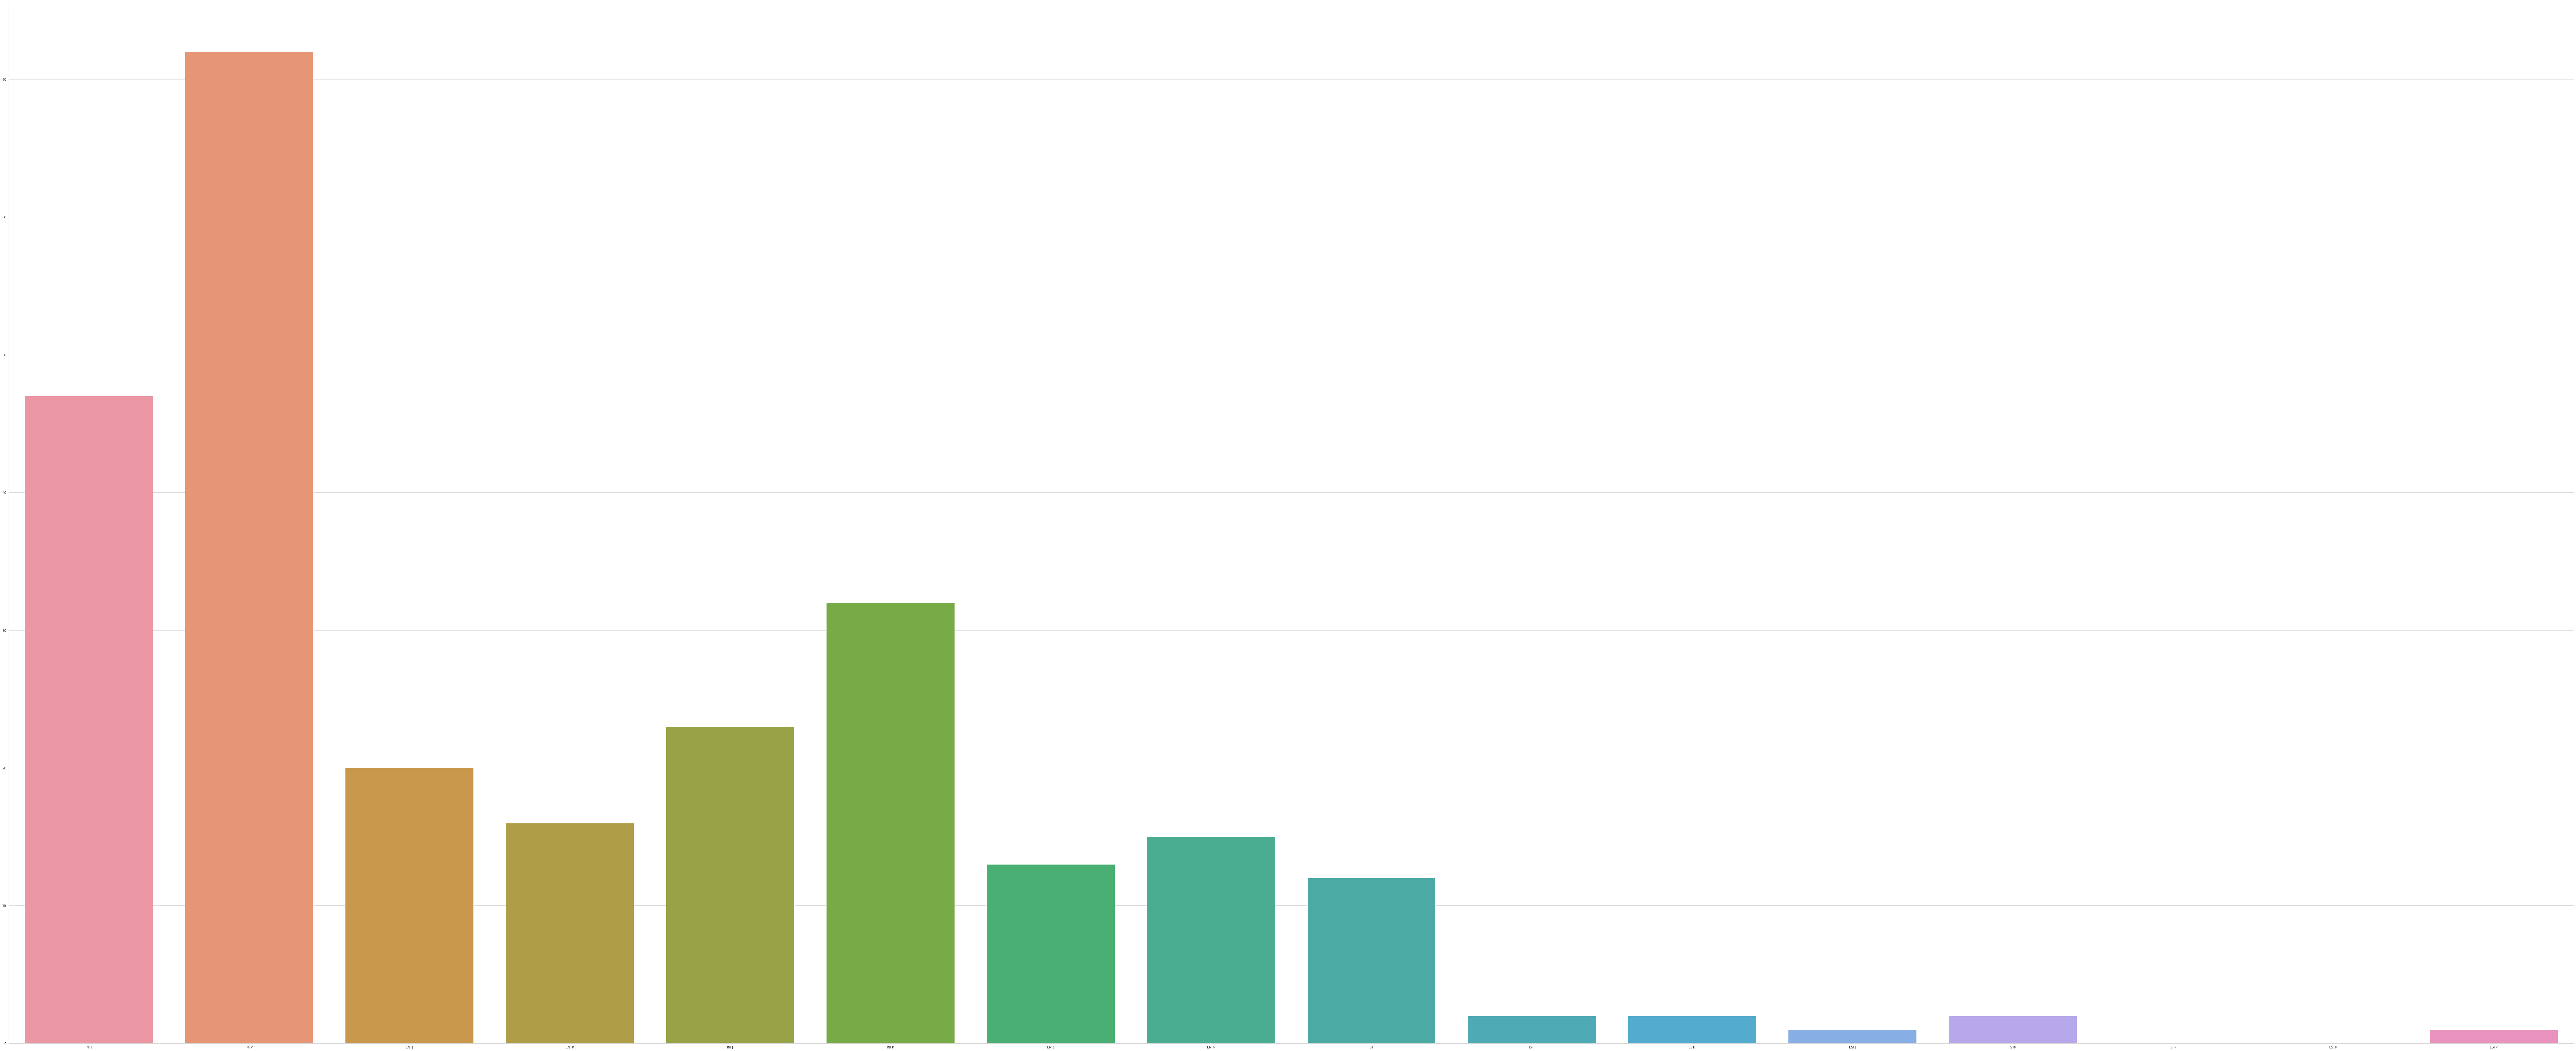

In [99]:
# creating a histogram of personality type frequency
plt.figure(figsize=(144,60))
sns.set_style("whitegrid")
ax = sns.barplot(x= personality_types, y= personality_counts, data=myers_responders)
plt.show()

## Individual User Files

Now that we have taken a look at the summary file, let's take a look at a single user file and then see how we can load all relevant user files into a dataframe for analysis.